## Automation Tool for matching terms in local XML files 
(version 07/08/2023)

Coded by Ella Li

Contributions by Jesse Johnston

### Import packages and settings

* pandas: a library for data manipulation and analysis.
* numpy: a library for scientific computing with Python.
* lxml: a library for processing XML and HTML documents.
* os: a library for operating system-related functions.
* re: a library for regular expressions, used for pattern matching.
* warnings: a library for issuing warnings to the user.
* plotly.express: a library for creating interactive plots and charts.
* plotly.io: Part of the Plotly library that provides functions for writing figures or data to various formats. These include, for instance, static image file formats like .jpeg or .png, and various textual formats such as .json or .html.
* matplotlib.pyplot: A plotting library used for creating static, animated, and interactive visualizations in Python. It provides an object-oriented API for embedding plots into applications.
* matplotlib.colors: A module of Matplotlib that is used for converting color or numbers arguments to RGB or RGBA. It provides functions for color specification conversions.
* nltk: The Natural Language Toolkit (NLTK) is a library for symbolic and statistical natural language processing for English. It provides easy-to-use interfaces to over 50 corpora and lexical resources, such as WordNet, along with a suite of text processing libraries for classification, tokenization, stemming, tagging, parsing, and semantic reasoning.
* nltk.corpus.stopwords: This module is a part of NLTK, and is used to work with 'stop words'. Stop words are typically the most common words in a language like 'is', 'the', 'and', etc, and are often filtered out while processing the text data.
* string: A built-in module for common string operations. This library provides constants and utility functions for working with and manipulating text data.
* nltk.download('punkt'): This downloads the Punkt Tokenizer Models. These are pre-trained machine learning models for tokenizing text, or splitting text into smaller pieces, typically words.

In [1]:
import pandas as pd 
import numpy as np
from lxml import etree
import os
import re
import warnings
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
import plotly.express as px
import plotly.io as pio
import nltk
from nltk.corpus import stopwords
import string
nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Jiaqi\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Jiaqi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Note on Packages

Some packages used for creating visualizations, such as Plotly, may require additional libraries to fully render and save images. If you encounter any errors or issues when generating plots or saving images, the error message will typically provide instructions on what additional libraries or dependencies you need to install.

For example, Plotly can require the kaleido package for static image export. If you don't have this package installed, you might see an error message like this when you try to save a Plotly figure as an image:

"ValueError: Image export using the 'kaleido' engine requires the kaleido package, which can be installed using pip:"

To resolve this, you would install the kaleido package as suggested in the error message:

- pip install kaleido

Always ensure that you have all the necessary dependencies installed for your data visualization packages to function correctly. If you're not sure, you can check the documentation for the specific package.

**Sets a filter for warnings if needed**:

In [2]:
# warnings.filterwarnings("ignore", category=UserWarning)

**pd.set_option('display.max_colwidth', -1)**: controls the maximum width of each column in a pandas dataframe. By setting it to -1, pandas will display the full contents of each column, without any truncation:

In [3]:
pd.set_option('display.max_colwidth', -1)

C:\Users\Jiaqi\AppData\Local\Temp\ipykernel_10512\3652881321.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


**pd.set_option('display.max_rows', None)**: Sets the maximum number of rows displayed when a pandas DataFrame or Series is printed to be unlimited. When this option is set to an integer (as in the commented line # **pd.set_option('display.max_rows', 10)**), only the specified number of rows would be displayed. This is useful for controlling the output length, especially when working with large DataFrames.

In [4]:
# pd.set_option('display.max_rows', None)
pd.set_option('display.max_rows', 10)

### Parsing XML to DataFrame
##### In this script, we cater to two common types of XML files:
##### 1. XML files without namespaces.
##### 2. XML files with namespaces.
##### Depending on the structure of your XML files and the namespaces used, you might need to tailor the respective functions. Please adjust these functions according to the type of XML files you are working with to ensure optimal results.

This function, parse_xml_to_df(xml_file), is designed to parse an XML file and convert its data into a pandas DataFrame for further analysis. This function forms the basis of the XML parsing process in the script.

It begins by parsing the XML file and extracting the root of the XML document. The filename (without extension) is also stored as it's used later.

The function then loops over all elements in the root of the XML document, extracting various pieces of information. For each element, a dictionary element_data is created to hold the extracted data. This dictionary includes the filename, EAD ID, title, abstract, language, scope content, control access (which further includes subjects, genre forms, geo names, person names, corporate names, family names) and their respective sources, biography history, and custodian history.

Each dictionary is appended to a list data. Finally, this list of dictionaries is converted into a DataFrame. Only those dictionaries that contain more than four key-value pairs are included in the DataFrame, which helps filter out any elements with insufficient/nonsense data.

In [5]:
# parse the xml file without namespaces

def parse_xml_to_df(xml_file):
    
    try:
        # Parse the XML file
        tree = etree.parse(xml_file)
        root = tree.getroot()
        
        # Get the filename without the extension
        filename = os.path.basename(xml_file)

        # Create a list to store the data
        data = []

        # Iterate over all elements in the XML file
        for element in root:
            # Create a dictionary to store the data for each element
            element_data = {}
            
            # add the filename
            element_data['source_filename'] = filename
            
            ## extract id
            eadid = root.find('.//eadid')
            if eadid is not None:
                element_data['ead_id'] = eadid.text.strip()  # Add strip() to remove leading and trailing white space
            
            publicid = eadid.get('publicid')
            if publicid is not None:
                result = re.search(r'::(.*)\.xml', publicid)
                if result:
                    public_id = result.group(1).split('::')[-1]
                    element_data['public_id'] = public_id    
            
            # Extract titleproper
            titleproper = root.find('.//titleproper')
            if titleproper is not None:
                element_data['titleproper'] = titleproper.text
            
            
            ## EXtract abstract
            abstract = element.find('.//abstract')
            if abstract is not None:
                element_data['abstract'] = abstract.text

            ## Extract language
            language = element.find('.//langmaterial')
            if language is not None:
                element_data['language'] = ''.join(language.itertext())

            ## Extract scopecontent
            scopecontent = element.findall('./scopecontent')
            if scopecontent:
                scopecontent_texts = []
                for sc in scopecontent:
                    paragraphs = sc.findall('./p')
                    if paragraphs:
                        for p in paragraphs:
                            p_text = ""
                            for child in p.itertext():
                                p_text += child
                            scopecontent_texts.append(p_text)
                element_data['scopecontent'] = '; '.join(scopecontent_texts)
            
            ## Extract controlaccess
            controlaccess = element.find('.//controlaccess')
            if controlaccess is not None:
                subjects = controlaccess.findall('.//subject')
                if subjects:
                    element_data['subjects'] = '; '.join([subject.text for subject in subjects])
                    # Extract the 'source' attribute for each 'subject' tag
                    element_data['subjects_source'] = '; '.join([subject.get('source') for subject in subjects if subject.get('source') is not None])

                genreforms = controlaccess.findall('.//genreform')
                if genreforms:
                    element_data['genreforms'] = '; '.join([genreform.text for genreform in genreforms])
                    # Extract the 'source' attribute for each 'genreform' tag
                    element_data['genreforms_source'] = '; '.join([genreform.get('source') for genreform in genreforms if genreform.get('source') is not None])

                geognames = controlaccess.findall('.//geogname')
                if geognames:
                    element_data['geognames'] = '; '.join([geogname.text for geogname in geognames])
                    # Extract the 'source' attribute for each 'geogname' tag
                    element_data['geognames_source'] = '; '.join([geogname.get('source') for geogname in geognames if geogname.get('source') is not None])

                persnames = controlaccess.findall('.//persname')
                if persnames:
                    element_data['persnames'] = '; '.join([persname.text for persname in persnames])
                    # Extract the 'source' attribute for each 'persname' tag
                    element_data['persnames_source'] = '; '.join([persname.get('source') for persname in persnames if persname.get('source') is not None])

                corpnames = controlaccess.findall('.//corpname')
                if corpnames:
                    element_data['corpnames'] = '; '.join([corpname.text for corpname in corpnames])
                    # Extract the 'source' attribute for each 'corpname' tag
                    element_data['corpnames_source'] = '; '.join([corpname.get('source') for corpname in corpnames if corpname.get('source') is not None])

                famnames = controlaccess.findall('.//famname')
                if famnames:
                    element_data['famnames'] = '; '.join([famname.text for famname in famnames])
                    # Extract the 'source' attribute for each 'famname' tag
                    element_data['famnames_source'] = '; '.join([famname.get('source') for famname in famnames if famname.get('source') is not None])

            ## Extract bioghist    
            bioghist = element.findall('./bioghist')
            if bioghist:
                bioghist_texts = []
                for bio in bioghist:
                    paragraphs = bio.findall('./p')
                    if paragraphs:
                        for p in paragraphs:
                            p_text = ""
                            for child in p.itertext():
                                p_text += child
                            bioghist_texts.append(p_text)
                element_data['bioghist'] = '; '.join(bioghist_texts)

            ## Extract custodhist
            custodhist = element.findall('./custodhist')
            if custodhist:
                custodhist_texts = []
                for cus in custodhist:
                    paragraphs = cus.findall('./p')
                    if paragraphs:
                        for p in paragraphs:
                            p_text = ""
                            for child in p.itertext():
                                p_text += child
                            custodhist_texts.append(p_text)
                element_data['custodhist'] = '; '.join(custodhist_texts)

            # Add the element data to the list of data
            data.append(element_data)

        # print(data)
        
        df = pd.DataFrame([d for d in data if len(d)>4])

    except:
        # If error, print the error message and skip the file
        print("Error parsing file:", xml_file)
        df = None
    
    return df

### Defining Namespace Prefix and URI

For XML files with namespaces, define the namespace prefix and URI. Replace the prefixes and URIs with those relevant to your specific XML files. For example, with SCRC files:

In [6]:
# Example for SCRC files:

namespaces = {
    "ead": "urn:isbn:1-931666-22-9",
    "xlink": "http://www.w3.org/1999/xlink",
    "xsi": "http://www.w3.org/2001/XMLSchema-instance"
}

In [7]:
# Parse xml file with namespaces - (FOR SCRC files in our example)

def parse_xml_to_df_ns(xml_file):
    try:
        
        # Parse the XML file
        tree = etree.parse(xml_file)
        root = tree.getroot()
        
        # Get the filename without the extension
        filename = os.path.basename(xml_file)

        # Create a list to store the data
        data = []

        # Iterate over all elements in the XML file
        for element in root:
            # Create a dictionary to store the data for each element
            element_data = {}

            # add the filename
            element_data['source_filename'] = filename
        
            ## extract id
            eadid = root.find('.//ead:eadid', namespaces)
            if eadid is not None:
                element_data['ead_id'] = eadid.text.strip()  # Add strip() to remove leading and trailing white space

            publicid = eadid.get('publicid')
            if publicid is not None:
                result = re.search(r'::(.*)\.xml', publicid)
                if result:
                    public_id = result.group(1).split('::')[-1]
                    element_data['public_id'] = public_id

                    
            # Extract titleproper
            titleproper = root.find('.//ead:titleproper', namespaces)
            if titleproper is not None:
                element_data['titleproper'] = titleproper.text
                
                
            ## extract abstract
            abstract = element.find('.//ead:abstract', namespaces)
            if abstract is not None:
                element_data['abstract'] = abstract.text
             
            ## Extract language
            language = root.findall('.//ead:langmaterial', namespaces)[-1]
            if language is not None:
                element_data['language'] = ''.join(language.itertext())
                
            ## Extract scopecontent
            scopecontent = element.find('.//ead:scopecontent', namespaces)
            if scopecontent is not None:
                scopecontent_texts = []
                p_elements = scopecontent.findall('.//ead:p', namespaces)
                for p in p_elements:
                    p_text = ""
                    for child in p.itertext():
                        p_text += child
                    scopecontent_texts.append(p_text)
                element_data['scopecontent'] = '; '.join(scopecontent_texts)    

            
            ## Extract bioghist    
            bioghist = element.find('.//ead:bioghist', namespaces)
            if bioghist is not None:
                bioghist_texts = []
                p_elements = bioghist.findall('.//ead:p', namespaces)
                
                for p in p_elements:
                    p_text = ""
                    for child in p.itertext():
                        p_text += child
                    bioghist_texts.append(p_text)
                element_data['bioghist'] = '; '.join(bioghist_texts) 
           
            
            ## Extract custodhist    
            custodhist = element.find('.//ead:custodhist', namespaces)
            if custodhist is not None:
                custodhist_texts = []
                p_elements = custodhist.findall('.//ead:p', namespaces)
                
                for p in p_elements:
                    p_text = ""
                    for child in p.itertext():
                        p_text += child
                    custodhist_texts.append(p_text)
                element_data['custodhist'] = '; '.join(custodhist_texts)
            
            ## Extract controlaccess
            controlaccess = element.find('.//ead:controlaccess', namespaces)
            if controlaccess is not None:
                subjects = controlaccess.findall('.//ead:subject', namespaces)
                if subjects:
                    element_data['subjects'] = '; '.join([subject.text for subject in subjects])
                    element_data['subjects_source'] = '; '.join([subject.get('source') for subject in subjects if subject.get('source') is not None])

                genreforms = controlaccess.findall('.//ead:genreform', namespaces)
                if genreforms:
                    element_data['genreforms'] = '; '.join([genreform.text for genreform in genreforms])
                    element_data['genreforms_source'] = '; '.join([genreform.get('source') for genreform in genreforms if genreform.get('source') is not None])

                geognames = controlaccess.findall('.//ead:geogname', namespaces)
                if geognames:
                    element_data['geognames'] = '; '.join([geogname.text for geogname in geognames])
                    element_data['geognames_source'] = '; '.join([geogname.get('source') for geogname in geognames if geogname.get('source') is not None])

                persnames = controlaccess.findall('.//ead:persname', namespaces)
                if persnames:
                    element_data['persnames'] = '; '.join([persname.text for persname in persnames])
                    element_data['persnames_source'] = '; '.join([persname.get('source') for persname in persnames if persname.get('source') is not None])

                corpnames = controlaccess.findall('.//ead:corpname', namespaces)
                if corpnames:
                    element_data['corpnames'] = '; '.join([corpname.text for corpname in corpnames])
                    element_data['corpnames_source'] = '; '.join([corpname.get('source') for corpname in corpnames if corpname.get('source') is not None])

                famnames = controlaccess.findall('.//ead:famname', namespaces)
                if famnames:
                    element_data['famnames'] = '; '.join([famname.text for famname in famnames])
                    element_data['famnames_source'] = '; '.join([famname.get('source') for famname in famnames if famname.get('source') is not None])
                   
            # Add the element data to the list of data
            data.append(element_data)

        # Create a DataFrame from the list of data
        df = pd.DataFrame([d for d in data if len(d)>4])
        
    except:
        # If error, print the error message and skip the file
        print("Error parsing file:", xml_file)
        df = None

    return df

### An example: Parsing Single XML File   
In this section of the script, we illustrate how to parse XML file (with and without namespaces) and convert them into a DataFrame using the parse_xml_to_df and parse_xml_to_df_ns function we have.

Three example XML files are given (from the local path):   
1. 'RCRC_Finding_Aid_List_Bentley/Finding_Aids/umich-bhl-0052.xml'
2. 'SCRC_XML/adler_20221006_152012_UTC__ead.xml'
3. 'Clements_Library_Philippine_Islands_EAD/hillardlow_final.xml'

To parse the other files, simply replace xml_file_# with the desired file path.

The first and second files are parsed as examples:

In [8]:
# file path

xml_file_1 = 'RCRC_Finding_Aid_List_Bentley/Finding_Aids/umich-bhl-0052.xml'
xml_file_2 = 'SCRC_XML/adler_20221006_152012_UTC__ead.xml'
xml_file_3 = 'Clements_Library_Philippine_Islands_EAD/hillardlow_final.xml'

# parse one xml file (without namespace)

df = parse_xml_to_df(xml_file_1)
df.style.set_properties(**{'text-align': 'left'}) # align text to the left (if needed)

In [9]:
# parse one xml file (with namespace)

df = parse_xml_to_df_ns(xml_file_2)
df.style.set_properties(**{'text-align': 'left'})

### Parsing Multiple XML Files
This section includes two functions that allow you to parse multiple XML files from a given local directory at once. They consolidate the data from all files into a single DataFrame.

1. parse_xml_folder_to_df(folder_path): This function is for parsing multiple XML files without namespaces. 
2. parse_xml_folder_to_df_ns(folder_path): This function performs the same operations as the previous one but is intended for XML files with namespaces.

Both functions take as input a folder path (as a string) and return a single DataFrame containing the combined data from all the XML files in that folder. The resulting DataFrame's rows are concatenated with their original index ignored, ensuring a continuous index in the final DataFrame.

In [10]:
# Parsing Multiple XML Files (without namespace)

def parse_xml_folder_to_df(folder_path):
    # Create a list to store the dataframes for each file
    dfs = []
    
    # Loop over all XML files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".xml"):
            file_path = os.path.join(folder_path, filename)
            df = parse_xml_to_df(file_path)
            dfs.append(df)
    
    # Concatenate the dataframes into one dataframe
    result_df = pd.concat(dfs, ignore_index=True)
    
    return result_df

# Parsing Multiple XML Files (with namespace)

def parse_xml_folder_to_df_ns(folder_path):
    # Create a list to store the dataframes for each file
    dfs = []
    
    # Loop over all XML files in the folder
    for filename in os.listdir(folder_path):
        if filename.endswith(".xml"):
            file_path = os.path.join(folder_path, filename)
            df = parse_xml_to_df_ns(file_path)
            dfs.append(df)
    
    # Concatenate the dataframes into one dataframe
    result_df = pd.concat(dfs, ignore_index=True)
    
    return result_df

#### Selecting and Parsing XML Files from Local Directories

This part of the script parses multiple XML files from specified local directories. You can change the folder paths according to your needs.

Three folders are currently specified:

1. folder1_path: "RCRC_Finding_Aid_List_Bentley/Finding_Aids"
2. folder2_path: "Clements_Library_Philippine_Islands_EAD"
3. folder3_path: "SCRC_XML"

Each folder is parsed using the appropriate function based on whether the XML files contain namespaces or not. The extracted data is saved into DataFrames:

1. Bentley data (df1_Bentley) is extracted from the first folder using the parse_xml_folder_to_df function, which is for XML files without namespaces.
2. Clements data (df2_Clements) is extracted from the second folder using the same function.
3. SCRC data (df3_SCRC) is extracted from the third folder using the parse_xml_folder_to_df_ns function, which is for XML files with namespaces.

Each resulting DataFrame contains data from all the XML files in the respective folder. (If you want the data to be left-aligned, you can uncomment and use the style.set_properties function.)

In [11]:
# select/ change local file path

folder1_path = "RCRC_Finding_Aid_List_Bentley/Finding_Aids"
folder2_path = "Clements_Library_Philippine_Islands_EAD"
folder3_path = "SCRC_XML"

In [12]:
# display parsed data - Bentley 

df1_Bentley = parse_xml_folder_to_df(folder1_path)
# df1_Bentley

In [13]:
# display parsed data - Clements
df2_Clements = parse_xml_folder_to_df(folder2_path)

df2_Clements

source_filename                 ead_id  \
0   abbottfam_final.xml           umich-wcl-M-3378.3abb   
1   ackerburgr_final.xml          umich-wcl-M-3397.6ack   
2   algerr_final.xml              umich-wcl-M-417alg      
3   andersonm_final.xml           umich-wcl-F-612and      
4   bisbeew_final.xml             umich-wcl-M-7074bis     
..                ...                             ...     
62  usservicemanmanila_final.xml  umich-wcl-M-4409.3uss   
63  weile_final.xml               umich-wcl-M-3201wei     
64  whallone_final.xml            umich-wcl-M-2755wha     
65  whittemorelow_final.xml       umich-wcl-M-2440whi     
66  wochnac_final.xml             umich-wcl-M-3359.3woc   

                   public_id  \
0   abbottfam_final            
1   ackerburgr_final           
2   algerr_final               
3   andersonm_final            
4   bisbeew_final              
..            ...              
62  usservicemanmanila_final   
63  weile_final                
64  whallone_final             
65  whittemorelow_final        
66  wochnac_final              

                                                                 titleproper  \
0   Finding Aid for Abbott Family Papers                                       
1   Finding Aid for Robert B. Ackerburg Correspondence                         
2   Finding Aid for Russell A. Alger Family Papers                             
3   Finding Aid for \nMark A. Anderson Collection of Post-Mortem Photography   
4   Finding Aid for \nWilliam Henry Bisbee Collection                          
..                                                ...                          
62  Finding Aid for U.S. Serviceman's Letters, Manila (Philippines)            
63  Finding Aid for Elsie F. Weil Collection                                   
64  Finding Aid for Ella St. John Whallon Collection                           
65  Finding Aid for Whittemore-Low Family Papers                               
66  Finding Aid for Charles Wochna Letters                                     

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   abstract  \
0    The Abbott family papers consist primarily of the correspondence of Bessie Abbott, an aspiring singer and stage performer, written to her family during the early 20th century.                                                                                                                                                                                                                                                                                                                                                                                                          
1    The Robert B. Ackerburg correspondence consists of a series of letters Ackerburg wrote to his friend, Suki Rochford, during his time in the merchant marine immediately following the Second World War.                                                                                                                                                                                                                                                                                                                                                                                  
2    The Russell A. Alger family papers contain personal and professional correspondence of Alger, who served as governor of Michigan (1885-1887), United States Secretary of War (1897-1899), and United States Senator (1902-1907).  The co

In [14]:
# display parsed data - SCRC 

df3_SCRC = parse_xml_folder_to_df_ns(folder3_path)

# df3_SCRC

### Exporting DataFrames to CSV Files

This section of the script exports the parsed data in the DataFrames (df1_Bentley, df2_Clements, and df3_SCRC) to CSV files. This allows for the storage and further analysis of the extracted data.

The CSV files will be named 'df1_Bentley.csv', 'df2_Clements.csv', and 'df3_SCRC.csv' respectively and will be saved in the same directory as your script.

The index=True argument indicates that the DataFrame index will also be saved in the CSV file. If you don't want to include the index, you can set index=False.

Modify the file names and paths as per your needs before running this part of the script.

In [15]:
# export

df1_Bentley.to_csv('df1_Bentley.csv', index=True)
df2_Clements.to_csv('df2_Clements.csv', index=True)
df3_SCRC.to_csv('df3_SCRC.csv', index=True)

### Term Matching

This part of the script enables matching specific terms in your dataset. These terms are defined in a text file (e.g., 'terms_all.txt'), where each line contains one term. First, the script reads the term file, creating a list of terms to match. The structure of the text file should be such that each term is on a separate line.

Next, the match_terms function is defined. This function searches for each term in the specified columns of a given row in your DataFrame. It performs an exact match, searching for the whole term, not part of it (due to the use of the '\b' word boundary in the regular expression). The search is case-insensitive due to the re.IGNORECASE flag.

If a term is found in a paragraph of the column, a dictionary is created with details about the match, including the term, the number of matches in the paragraph, the paragraph text itself, and other related information. These dictionaries are appended to the results list.

Replace 'terms_all.txt' with the name of your own term list file. Adjust the match_terms function as needed, depending on your specific term-matching requirements.

In [16]:
# read in the txt file term list
with open('terms_all.txt', 'r') as f:
    terms = [line.strip() for line in f]

In [17]:
# check the term list we get from txt
# terms

In [18]:
# match term

def match_terms(row, terms, columns):
    results = []
    for term in terms:
        for col in columns:
            if not isinstance(row[col], float):
                # split the column into paragraphs
                paragraphs = row[col].split('\n')
                # loop through each paragraph
                for paragraph in paragraphs:
                    # check if the term is in the current paragraph
                    if re.search(r'\b' + re.escape(term) + r'\b', paragraph, re.IGNORECASE):
                        results.append({
                            'ead_id': row['ead_id'],
                            'source_filename': row['source_filename'],
                            'titleproper': row.get('titleproper', None), 
                            'Term': term, 
                            'Matched_Times': len(re.findall(r'\b' + re.escape(term) + r'\b', paragraph, re.IGNORECASE)),
                            'Matched_From': col, 
                            'Matched_Paragraph': paragraph
                        })
    return results
                          

### Matching Results and Visualizations

In this segment, the script matches terms from the defined list in the provided DataFrames, generates frequency tables of matched terms, creates visualizations, and exports the results to CSV files.

match_and_visualize(df, name): This function applies the previously defined match_terms function to each row in the input DataFrame (df). Matched terms, along with related information, are stored in results_df. This DataFrame is then displayed, and a CSV file of the results is created.

calculate_term_frequency(df, df_name): This function creates a term frequency table for the matched terms in the input DataFrame (df).

These functions are applied to a list of DataFrames (i.e., 'Bentley', 'Clements', and 'SCRC') and the resulting match results are stored in a dictionary for subsequent visualization. The visualize_all(matched_results) function creates bar plots for the term frequencies in each DataFrame. 

(Do note that Jupyter Notebook might render some text in italics due to its LaTeX interpretation. This won't affect the actual data or the exported CSV files. )

Modify the function parameters and output filenames as per your requirements:

In [19]:
def match_and_visualize(df, name):
    # Match results
    results_df = pd.DataFrame([result for index, row in df.iterrows() for result in match_terms(row, terms, df.columns)])
    
    # Show matched results
    print("Matched results for ", name)
    display(results_df) # control dislay

    # Export to CSV
    results_df.to_csv('matched_results_' + name + '.csv', index=True)
    return results_df  # Return the DataFrame for later use


def calculate_term_frequency(df, df_name):
    term_frequency = df.groupby('Term')['Matched_Times'].sum().reset_index()
    term_frequency.rename(columns={'Matched_Times': 'Total_Frequency'}, inplace=True)
    term_frequency['DataFrame'] = df_name

    # Sort in descending order
    term_frequency.sort_values(by='Total_Frequency', ascending=False, inplace=True)
    
    # Show frequency table
    print("Term frequency for ", df_name)
    display(term_frequency)

    return term_frequency


# for each file pool
file_list = [(df1_Bentley, 'Bentley'), (df2_Clements, 'Clements'), (df3_SCRC, 'SCRC')]
matched_results = {name: match_and_visualize(df, name) for df, name in file_list}

Matched results for  Bentley


ead_id     source_filename  \
0    umich-bhl-0375  umich-bhl-0375.xml   
1    umich-bhl-0420  umich-bhl-0420.xml   
2    umich-bhl-0420  umich-bhl-0420.xml   
3    umich-bhl-0420  umich-bhl-0420.xml   
4    umich-bhl-0420  umich-bhl-0420.xml   
..              ...                 ...   
181  umich-bhl-9573  umich-bhl-9573.xml   
182  umich-bhl-9833  umich-bhl-9833.xml   
183  umich-bhl-9840  umich-bhl-9840.xml   
184  umich-bhl-9940  umich-bhl-9940.xml   
185  umich-bhl-9961  umich-bhl-9961.xml   

                                                                                           titleproper  \
0    Finding Aid for Museum of Anthropological Archaeology (University of Michigan) Records, 1894-2011   
1    Finding aid for the Albert Kahn Associates records, 1825-2014                                       
2    Finding aid for the Albert Kahn Associates records, 1825-2014                                       
3    Finding aid for the Albert Kahn Associates records, 1825-2014                                       
4    Finding aid for the Albert Kahn Associates records, 1825-2014                                       
..                                                             ...                                       
181  Finding Aid for Walker Lee Cisler Papers                                                            
182  Finding Aid for Edward Gajec Papers                                                                 
183  Finding aid for Charles W. Lane papers, 1935-1997                                                   
184  Finding Aid for James J. Blanchard Papers, 1982-2002                                                
185  Finding Aid for Frank R. Kennedy Papers                                                             

        Term  Matched_Times  Matched_From  \
0    Native   1              bioghist       
1    Death    1              scopecontent   
2    Death    2              bioghist       
3    Death    1              abstract       
4    Remains  1              scopecontent   
..       ... ..                       ...   
181  Death    1              bioghist       
182  Death    1              bioghist       
183  Types    1              scopecontent   
184  Remains  2              scopecontent   
185  Death    1              bioghist       

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                  

Matched results for  Clements


ead_id          source_filename  \
0    umich-wcl-M-417alg     algerr_final.xml          
1    umich-wcl-M-417alg     algerr_final.xml          
2    umich-wcl-M-417alg     algerr_final.xml          
3    umich-wcl-M-417alg     algerr_final.xml          
4    umich-wcl-F-612and     andersonm_final.xml       
..                  ...                     ...       
120  umich-wcl-M-2440whi    whittemorelow_final.xml   
121  umich-wcl-M-2440whi    whittemorelow_final.xml   
122  umich-wcl-M-2440whi    whittemorelow_final.xml   
123  umich-wcl-M-2440whi    whittemorelow_final.xml   
124  umich-wcl-M-3359.3woc  wochnac_final.xml         

                                                                  titleproper  \
0    Finding Aid for Russell A. Alger Family Papers                             
1    Finding Aid for Russell A. Alger Family Papers                             
2    Finding Aid for Russell A. Alger Family Papers                             
3    Finding Aid for Russell A. Alger Family Papers                             
4    Finding Aid for \nMark A. Anderson Collection of Post-Mortem Photography   
..                                                                        ...   
120  Finding Aid for Whittemore-Low Family Papers                               
121  Finding Aid for Whittemore-Low Family Papers                               
122  Finding Aid for Whittemore-Low Family Papers                               
123  Finding Aid for Whittemore-Low Family Papers                               
124  Finding Aid for Charles Wochna Letters                                     

        Term  Matched_Times  Matched_From  \
0    Hygiene  1              scopecontent   
1    Colony   1              bioghist       
2    Death    1              scopecontent   
3    Death    1              bioghist       
4    Hygiene  1              bioghist       
..       ... ..                   ...       
120  Types    1              scopecontent   
121  Death    1              scopecontent   
122  Death    1              scopecontent   
123  Death    1              scopecontent   
124  Death    1              scopecontent   

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

Matched results for  SCRC


ead_id  \
0   umich-scl-ams0025            
1   umich-scl-ams0059            
2   umich-scl-ams0066            
3   umich-scl-ams0066            
4   umich-scl-ams0067            
..                ...            
21  umich-scl-umpresspasternak   
22  umich-scl-weber              
23  umich-scl-welsh              
24  umich-scl-welsh              
25  umich-scl-welsh              

                                    source_filename  \
0   ams.0025_20221006_152051_UTC__ead.xml             
1   ams.0059_20221006_152030_UTC__ead.xml             
2   ams.0066_20221006_151503_UTC__ead.xml             
3   ams.0066_20221006_151503_UTC__ead.xml             
4   ams.0067_20221006_151857_UTC__ead.xml             
..                                    ...             
21  UM_Press_Pasternak_20221006_152244_UTC__ead.xml   
22  weber_20221006_151638_UTC__ead.xml                
23  welsh_20221006_151818_UTC__ead.xml                
24  welsh_20221006_151818_UTC__ead.xml                
25  welsh_20221006_151818_UTC__ead.xml                

                                                                      titleproper  \
0   Maria C. Lanzar-Carpio Papers                                                   
1   Luke Wright papers                                                              
2   Lowell, Arthur J. papers                                                        
3   Lowell, Arthur J. papers                                                        
4   John J. Pershing Papers                                                         
..                      ...                                                         
21  Finding aid for\n\nUniversity of Michigan Press Pasternak Records, 1958-1988    
22  Finding Aid for the Edward C. Weber Papers,                                     
23  Herbert Welsh Papers                                                            
24  Herbert Welsh Papers                                                            
25  Herbert Welsh Papers                                                            

                  Term  Matched_Times  Matched_From  \
0   Annex               1              bioghist       
1   Indigenous          1              scopecontent   
2   Philippine Islands  1              bioghist       
3   Dead                1              scopecontent   
4   Moro                1              bioghist       
..   ...               ..                   ...       
21  Philippine Islands  1              bioghist       
22  Types               1              scopecontent   
23  Indigenous          2              bioghist       
24  Native              1              bioghist       
25  Death               1              abstract       

                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        

Term frequency for  Bentley


Term  Total_Frequency DataFrame
6   Death                    52               Bentley 
20  Philippine Islands       35               Bentley 
7   Dwellings                34               Bentley 
18  Native                   17               Bentley 
11  Igorot                   15               Bentley 
..     ...                   ..                   ... 
9   Hanging                  1                Bentley 
8   Executions               1                Bentley 
21  Plantations              1                Bentley 
2   Colonialism              1                Bentley 
0   Benevolent Assimilation  1                Bentley 

[30 rows x 3 columns]

Term frequency for  Clements


Term  Total_Frequency DataFrame
6   Death               48               Clements
3   Colonial            16               Clements
19  Native              13               Clements
8   Enemy               12               Clements
21  Philippine Islands  12               Clements
..                 ...  ..                    ...
11  Hanged              1                Clements
18  Massacre            1                Clements
17  Lepers              1                Clements
1   Bone                1                Clements
0   Balangiga Massacre  1                Clements

[33 rows x 3 columns]

Term frequency for  SCRC


Term  Total_Frequency DataFrame
2   Death           6                SCRC    
1   Dead            3                SCRC    
5   Indigenous      3                SCRC    
6   Moro            3                SCRC    
9   Native          3                SCRC    
..     ...         ..                 ...    
0   Annex           1                SCRC    
4   Execution       1                SCRC    
7   Moro Rebellion  1                SCRC    
8   Moros           1                SCRC    
12  Type            1                SCRC    

[14 rows x 3 columns]

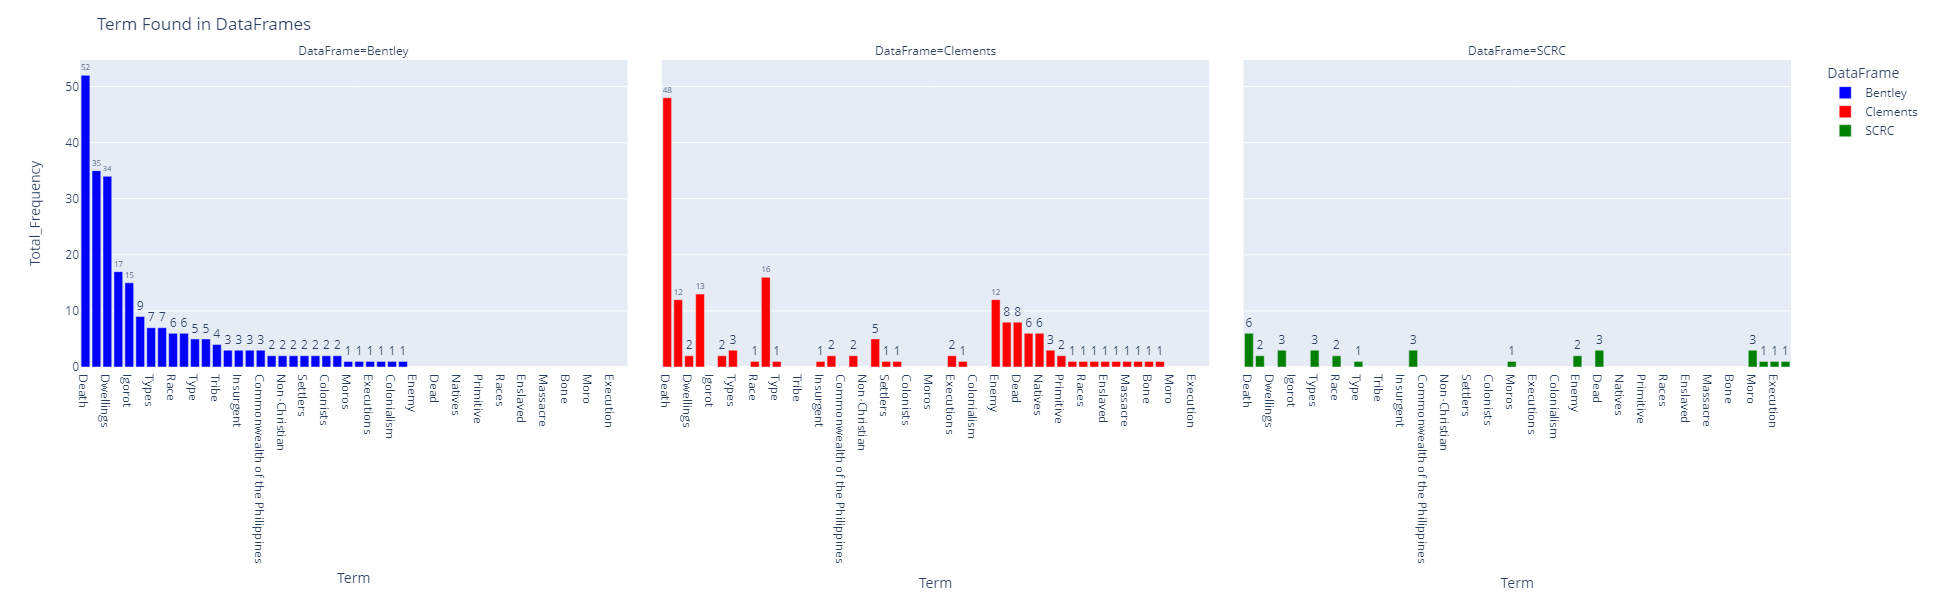

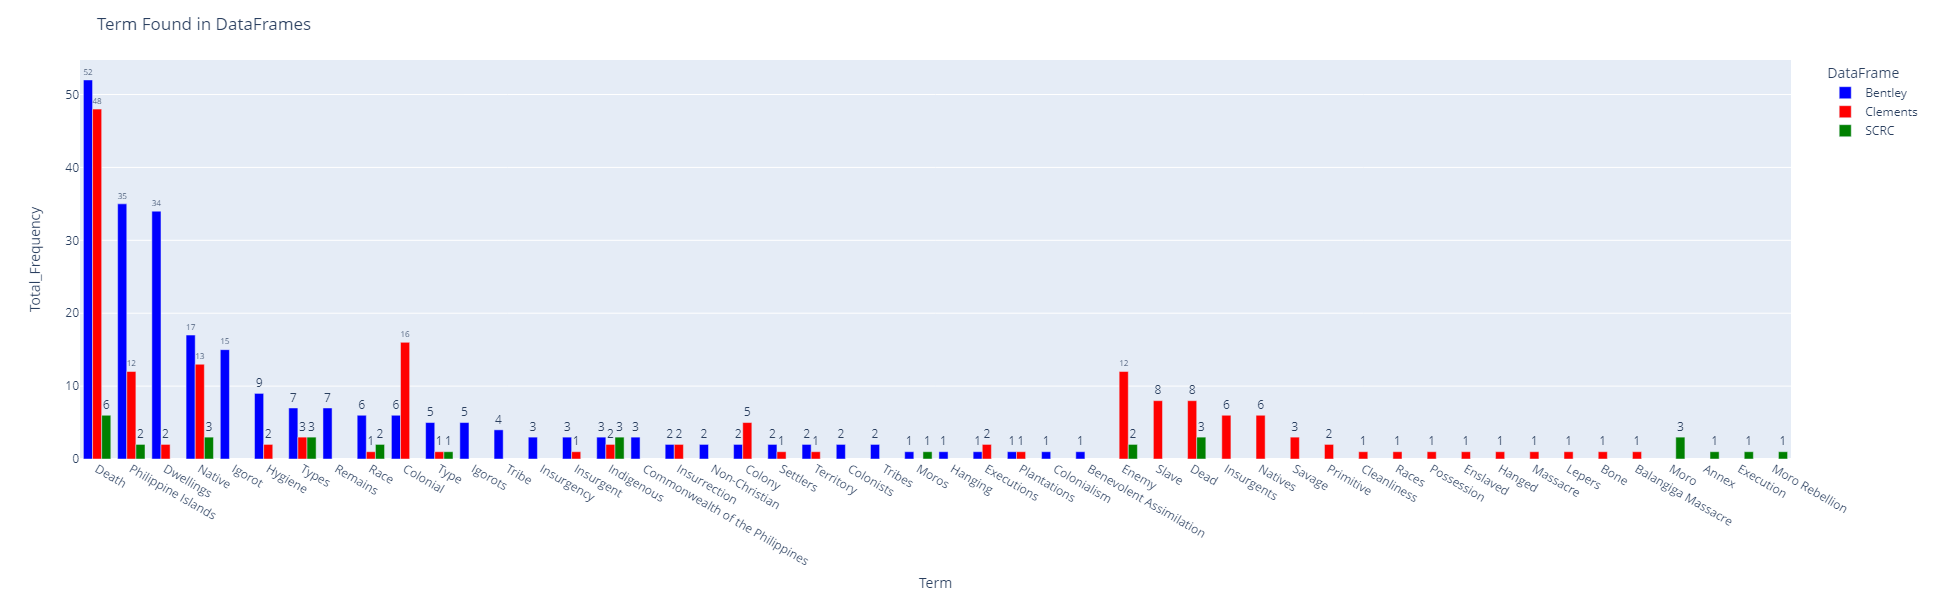

In [20]:
def visualize_all(matched_results):
    term_frequencies = pd.concat([calculate_term_frequency(df, name) for name, df in matched_results.items()])

    # Define a color dictionary for each dataframe
    colors = {'Bentley': 'blue', 'Clements': 'red', 'SCRC': 'green'}

    # Visualization
    fig = px.bar(term_frequencies, x='Term', y='Total_Frequency', text='Total_Frequency', 
                 color='DataFrame', color_discrete_map=colors, facet_col='DataFrame')
    fig.update_traces(textposition='outside', insidetextanchor='middle')
    fig.update_layout(title_text="Term Found in DataFrames", xaxis_title_standoff=10, height=600)
    fig.show()
    pio.write_image(fig, 'term_frequency_stacked.png')

    # Variation Visualization
    fig = px.bar(term_frequencies, x='Term', y='Total_Frequency', text='Total_Frequency', 
                 color='DataFrame', color_discrete_map=colors, barmode='group')
    fig.update_traces(textposition='outside', insidetextanchor='middle')
    fig.update_layout(title_text="Term Found in DataFrames", xaxis_title_standoff=10, height=600)
    fig.show()
    pio.write_image(fig, 'term_frequency_side_by_side.png')

visualize_all(matched_results)

### Identifying Elements with the Highest Term Occurrences

This section of the script helps identify the EAD (Encoded Archival Description) elements with the highest occurrences of the specified harmful terms.

The function calculate_element_frequency(df, df_name) is used to calculate the sum of matched terms for each subsection in a DataFrame. The results are sorted in descending order and returned as a DataFrame with columns 'Subsection', 'harmful_terms_frequency', and 'Source'.

This function is applied to each DataFrame in matched_results, and the results are concatenated into a single DataFrame, all_element_frequencies.

Finally, a grouped bar chart is created to visualize the frequency of terms across different subsections and sources.

In this chart, the x-axis represents the subsections, the y-axis shows the frequency of harmful terms, and different colors distinguish between sources. The barmode='group' setting places the bars side by side for easier comparison between sources.

Element frequencies across all file pools:


Subsection  harmful_terms_frequency    Source
0   bioghist      105                      Bentley 
1   scopecontent  53                       Bentley 
2   subjects      37                       Bentley 
3   geognames     19                       Bentley 
4   abstract      17                       Bentley 
..       ...      ..                           ... 
5   persnames     2                        Clements
6   corpnames     1                        Clements
0   scopecontent  15                       SCRC    
1   bioghist      14                       SCRC    
2   abstract      3                        SCRC    

[16 rows x 3 columns]

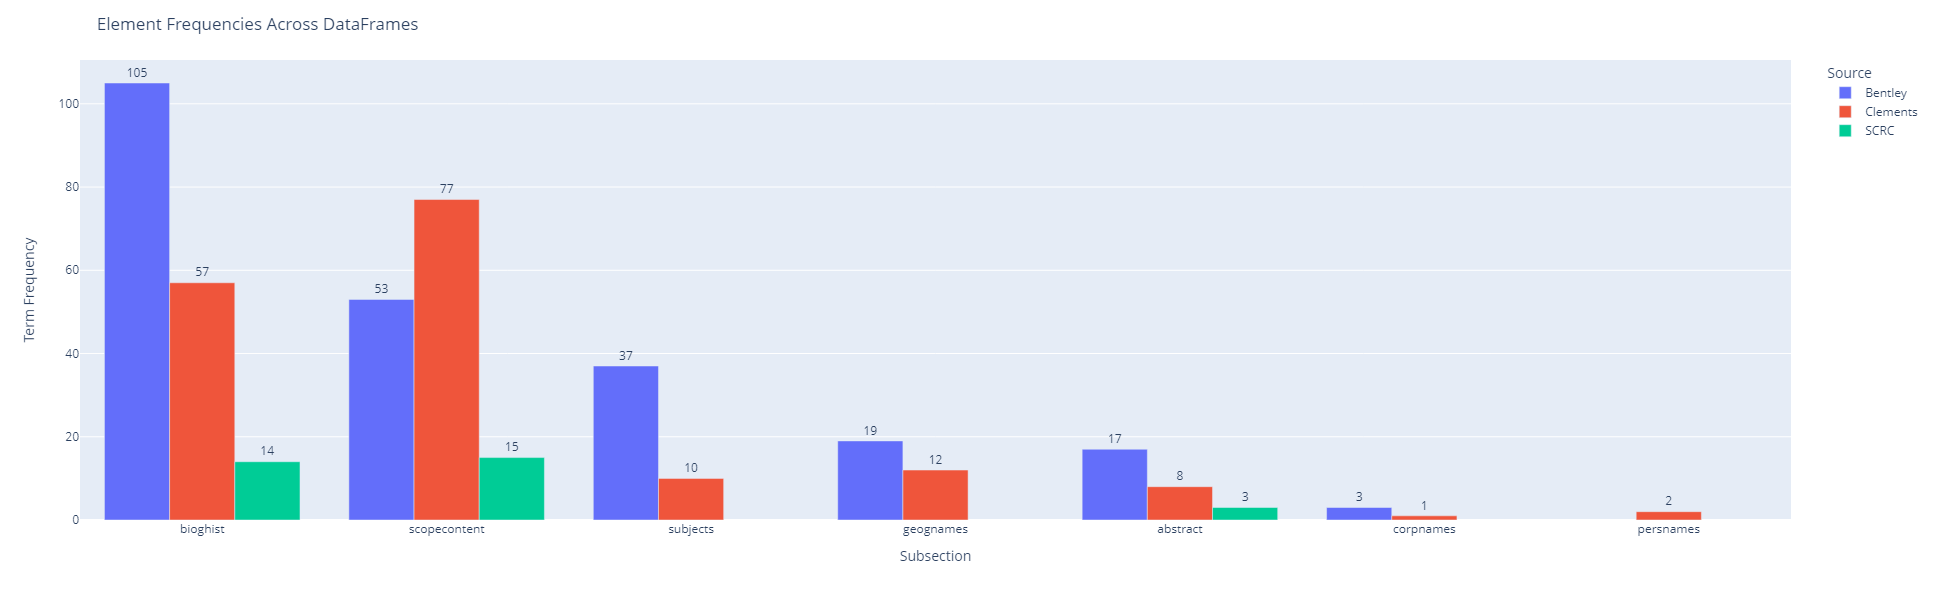

In [21]:
def calculate_element_frequency(df, df_name):
    element_counts = df.groupby('Matched_From')['Matched_Times'].sum()
    element_counts_sorted = element_counts.sort_values(ascending=False)
    df_element_counts = pd.DataFrame(list(element_counts_sorted.items()), columns=['Subsection', 'harmful_terms_frequency'])
    df_element_counts['Source'] = df_name  # Indicate the source dataframe
    return df_element_counts

# Use the function for each dataframes
element_frequencies_list = [calculate_element_frequency(df, name) for name, df in matched_results.items()]

# Concatenate all element frequencies
all_element_frequencies = pd.concat(element_frequencies_list)

# Show the DataFrame
print("Element frequencies across all file pools:")
display(all_element_frequencies)

# Visualization
fig = px.bar(all_element_frequencies, x='Subsection', y='harmful_terms_frequency', color='Source', text='harmful_terms_frequency')
fig.update_traces(textposition='outside')
fig.update_layout(title_text="Element Frequencies Across DataFrames", xaxis_title="Subsection", yaxis_title="Term Frequency", height=600, barmode='group')
fig.show()
pio.write_image(fig, 'element_frequency_across_dfs.png')

### Visualizing Term Frequencies Across Subsections

This segment of the script calculates the term frequencies in different subsections of each data source and visualizes the results using treemap and sunburst diagrams.

The calculate_subsection_term_frequency(df, df_name) function is used to calculate the sum of matched terms for each term in each subsection of a DataFrame. The results are returned as a DataFrame with columns 'Subsection', 'Term', 'Term_Frequency', and 'Source'. This function is applied to each DataFrame in matched_results, and the results are concatenated into a single DataFrame, all_subsection_term_frequencies.

Treemap diagrams are then created to visualize the frequencies of terms in each subsection for every data source. The size of each section in the treemap corresponds to the term frequency in that section. Two types of treemaps are generated: one with uniform colors and one with a color scale indicating term frequency. The color scale ranges from yellow ('Yl') for lower frequencies to red ('Rd') for higher frequencies.

A sunburst diagram is created with a similar color scale. In this diagram, the data sources are represented in the inner circle, subsections in the middle ring, and terms in the outer ring. This hierarchical view allows for easy comparison of term frequencies across different sources and subsections. The resulting visualizations are displayed but not saved. If you wish to save them, you can use fig.write_image('filename.png') as in the previous sections.

In [22]:
def calculate_subsection_term_frequency(df, df_name):
    subsection_term_frequency = df.groupby(['Matched_From', 'Term'])['Matched_Times'].sum().reset_index()
    subsection_term_frequency.rename(columns={'Matched_From': 'Subsection', 'Matched_Times': 'Term_Frequency'}, inplace=True)
    subsection_term_frequency['Source'] = df_name
    return subsection_term_frequency

# Use the function for each pool
subsection_term_frequencies_list = [calculate_subsection_term_frequency(df, name) for name, df in matched_results.items()]

# Concatenate all subsection term frequencies
all_subsection_term_frequencies = pd.concat(subsection_term_frequencies_list)


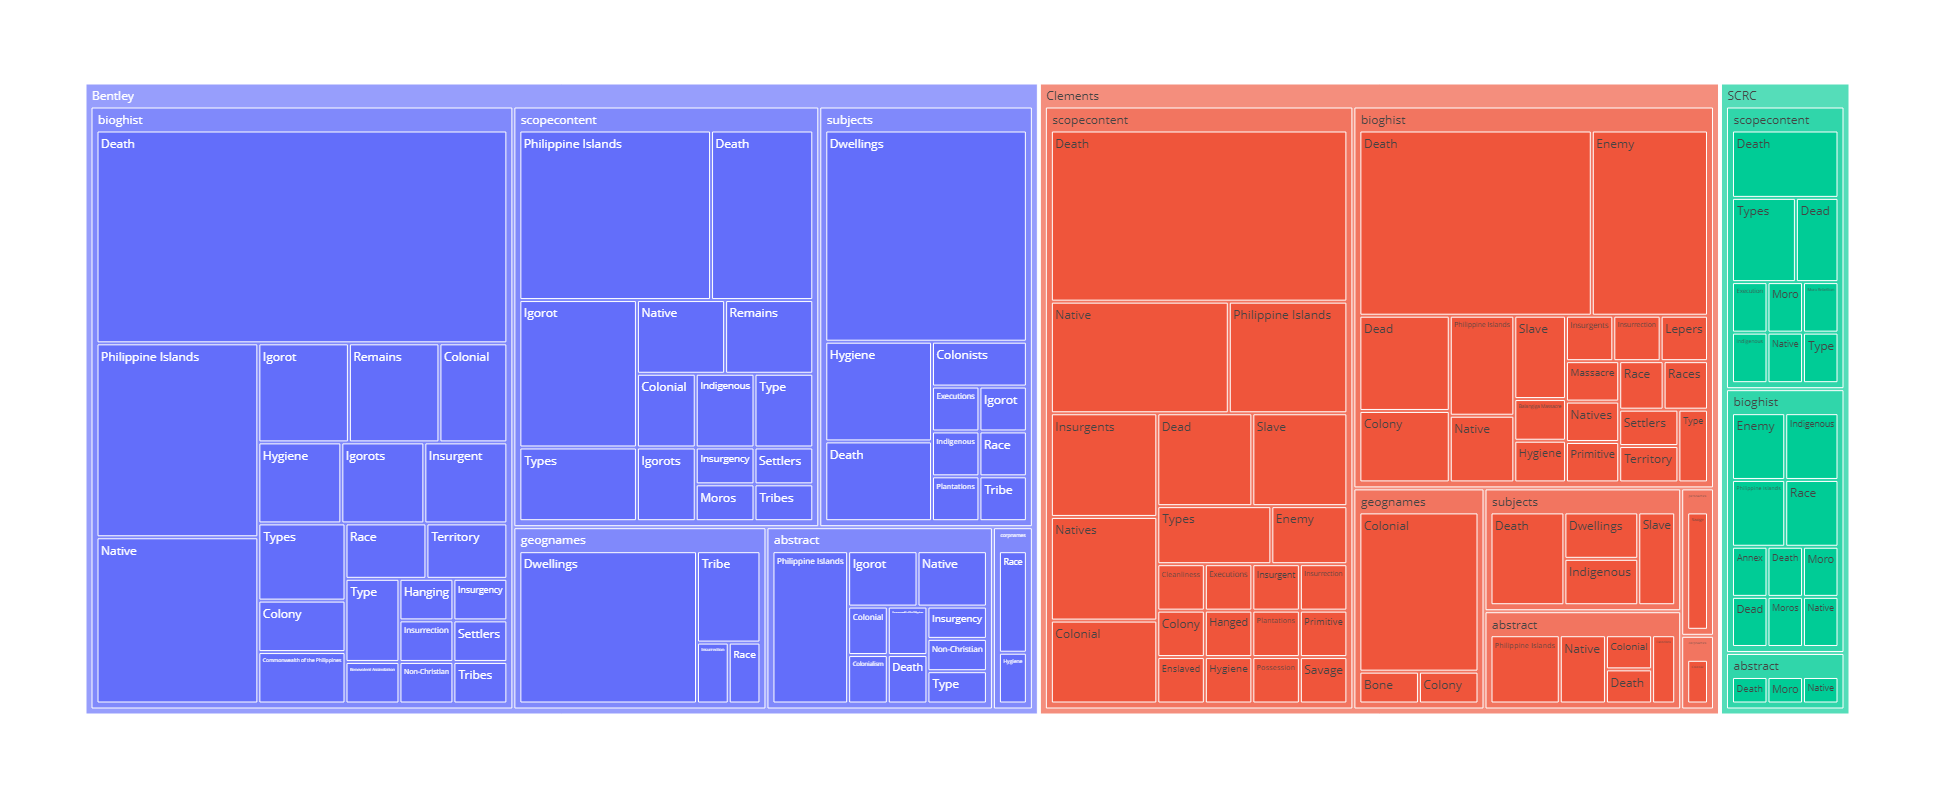

In [23]:
# Treemap
color_map = {'Bentley': 'blue', 'Clements': 'red', 'SCRC': 'green'}
fig = px.treemap(all_subsection_term_frequencies, path=['Source', 'Subsection', 'Term'], values='Term_Frequency')
fig.update_layout(width=1500, height=800)
fig.show()

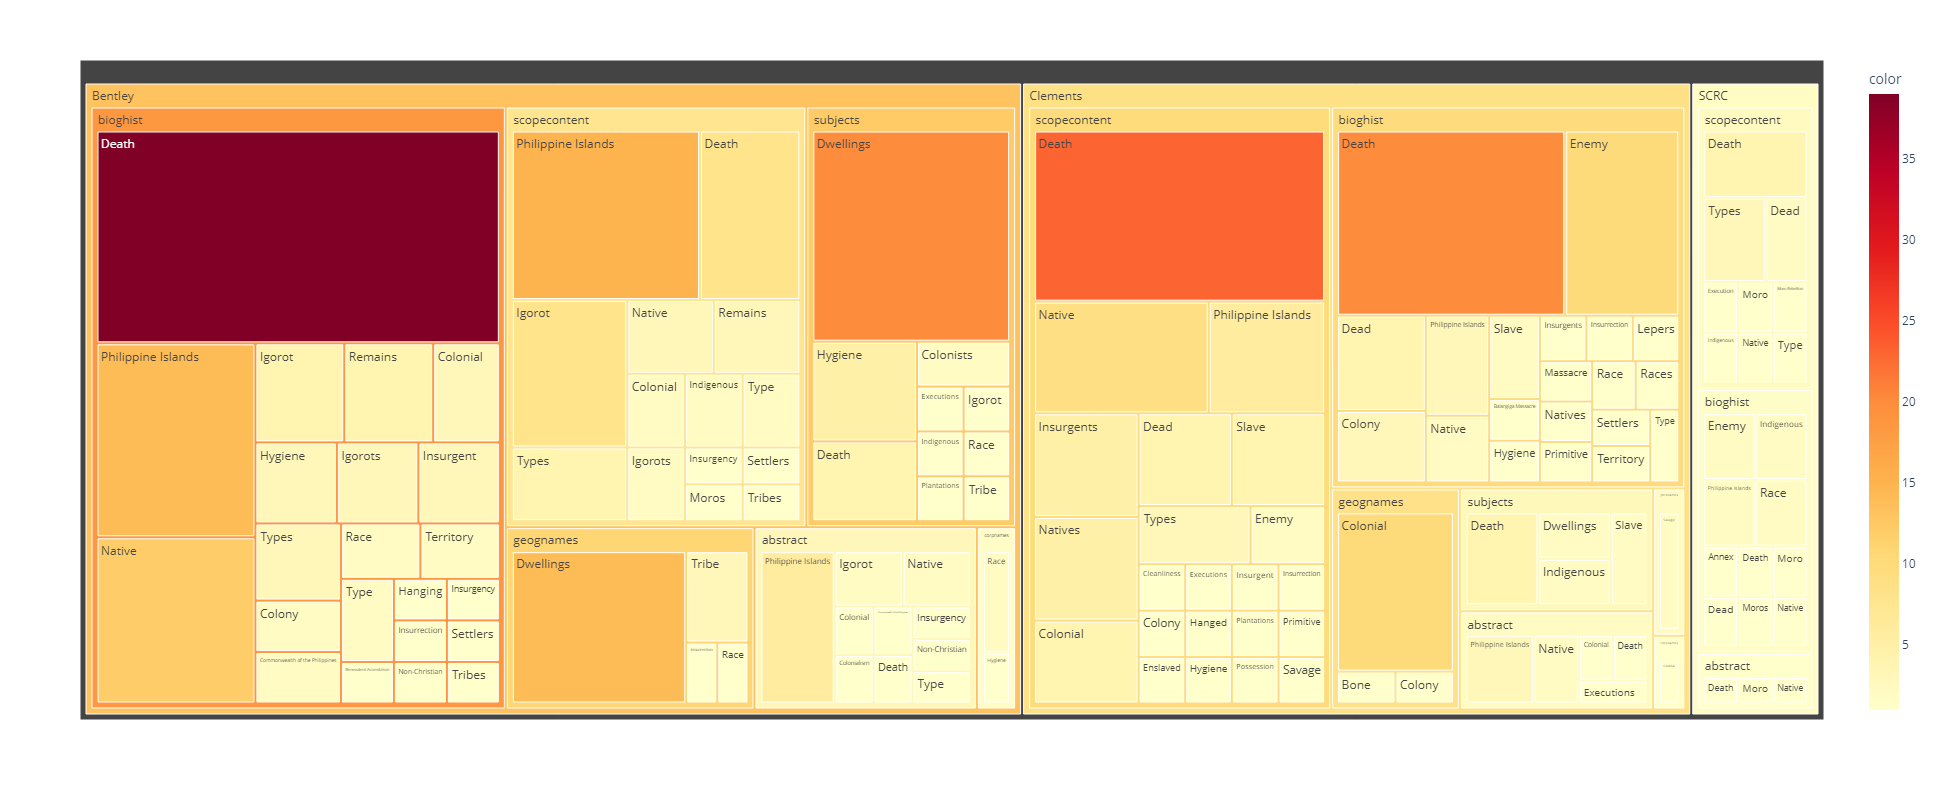

In [24]:
# Add a dummy color column
all_subsection_term_frequencies['color'] = all_subsection_term_frequencies['Term_Frequency']

# Treemap - color scale
fig = px.treemap(all_subsection_term_frequencies, path=['Source', 'Subsection', 'Term'], values='Term_Frequency',
                 color='color', color_continuous_scale='YlOrRd')
fig.update_layout(width=1500, height=800)
fig.show()


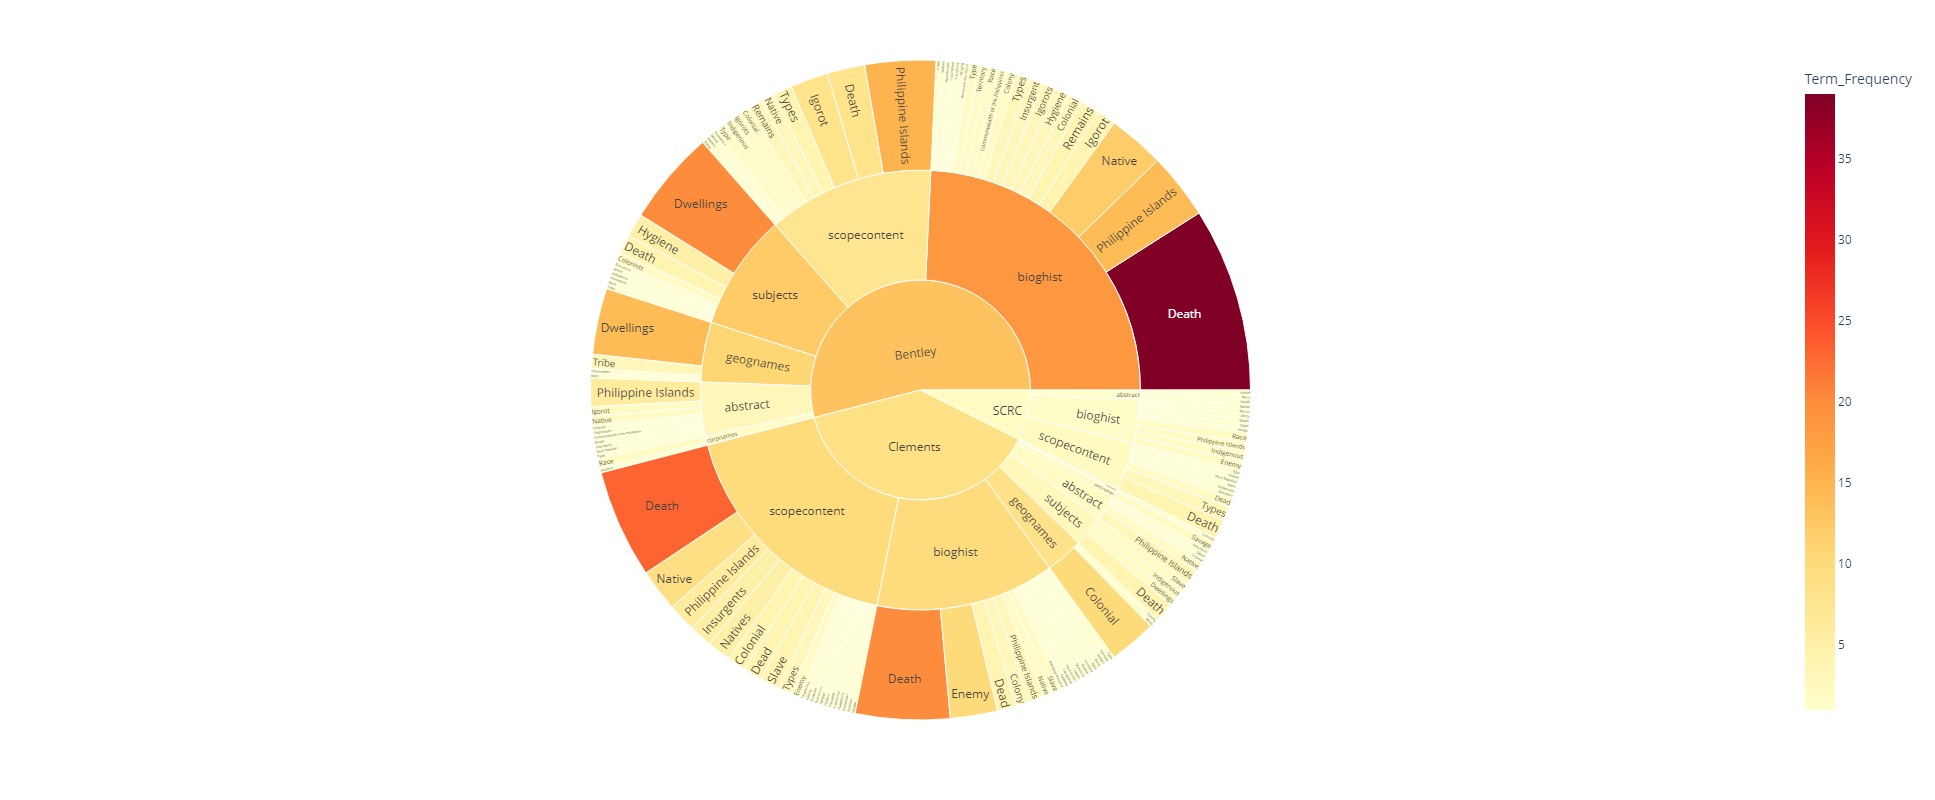

In [25]:
# Sunburst - color scale
fig = px.sunburst(all_subsection_term_frequencies, path=['Source', 'Subsection', 'Term'], values='Term_Frequency', 
                  color='Term_Frequency', color_continuous_scale='YlOrRd')
fig.update_layout(width=1300, height=800)
fig.show()

### Visualizing Source Frequencies

This section of the script is designed to create bar plots displaying the frequencies of different sources used in xml files 'controlaccess' section.

The source_columns list includes the following column names:

* 'subjects_source'
* 'genreforms_source'
* 'geognames_source'
* 'persnames_source'
* 'corpnames_source'
* 'famnames_source'

You can modify this list according to the source columns present in your specific DataFrames.

Note: In the case where a DataFrame doesn't have the specified column, an empty series is created to prevent errors. The sources in the column are separated using str.split('; ').explode(), which handles multiple sources in the same cell.

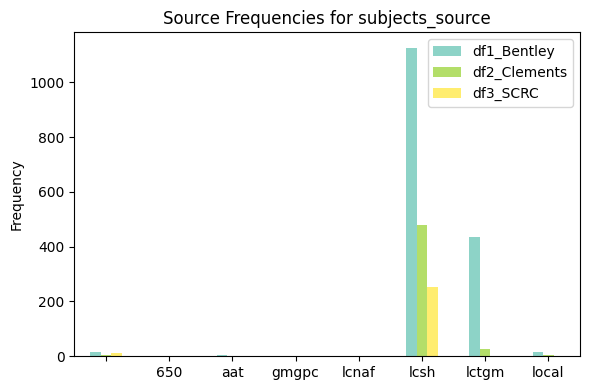

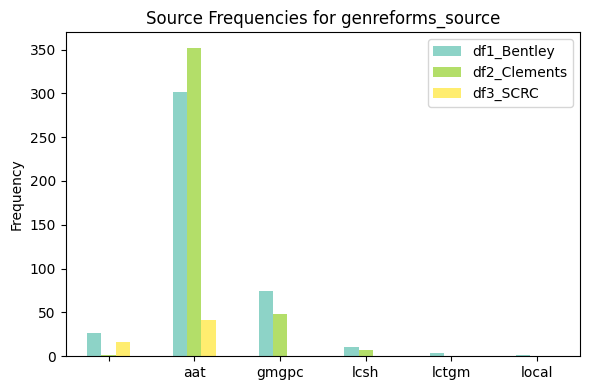

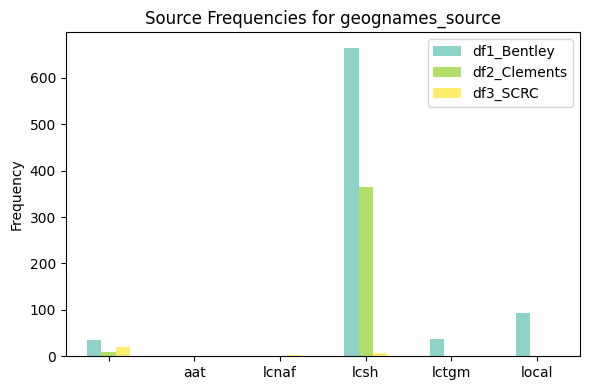

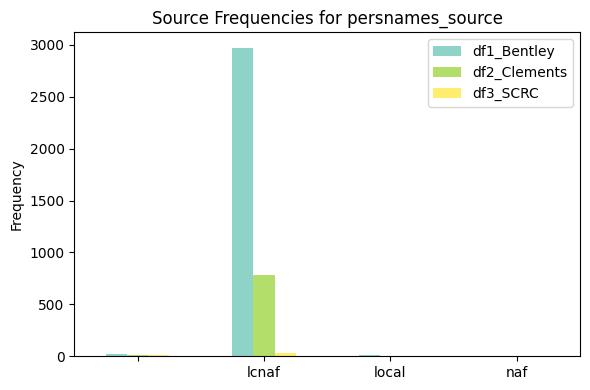

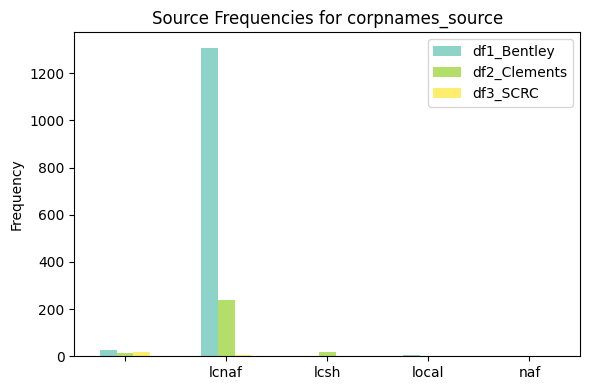

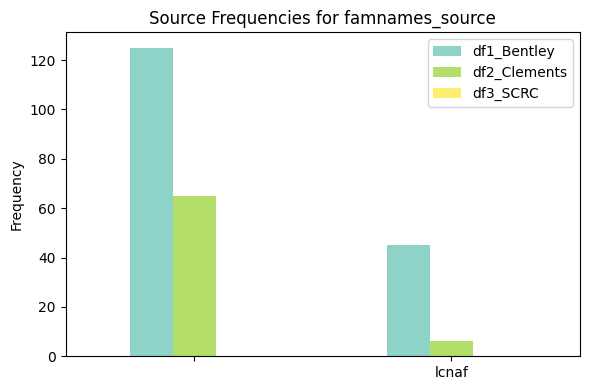

In [26]:
def plot_source_frequencies(df1, df2, df3, df1_name, df2_name, df3_name, column):
    if column in df1.columns:
        df1_counts = df1[column].fillna('').str.split('; ').explode().value_counts()
    else:
        df1_counts = pd.Series(dtype='int')
        
    if column in df2.columns:
        df2_counts = df2[column].fillna('').str.split('; ').explode().value_counts()
    else:
        df2_counts = pd.Series(dtype='int')
        
    if column in df3.columns:
        df3_counts = df3[column].fillna('').str.split('; ').explode().value_counts()
    else:
        df3_counts = pd.Series(dtype='int')

    # Create a new DataFrame to store these counts
    counts_df = pd.DataFrame({
        df1_name: df1_counts,
        df2_name: df2_counts,
        df3_name: df3_counts
    }).fillna(0)

    # Create a color palette
    cmap = plt.cm.get_cmap('Set3')
    colors = cmap([0.0, 0.5, 1.0])

    # Plot with rotated x-axis labels
    counts_df.plot(kind='bar', figsize=(6, 4), rot=0, color=colors)
    plt.title(f'Source Frequencies for {column}')
    plt.ylabel('Frequency')
    plt.tight_layout()
    plt.show()

# Specify the source columns
source_columns = ['subjects_source', 'genreforms_source', 'geognames_source', 'persnames_source', 'corpnames_source', 'famnames_source']

# Call the function for each source column
for column in source_columns:
    plot_source_frequencies(df1_Bentley, df2_Clements, df3_SCRC, 'df1_Bentley', 'df2_Clements', 'df3_SCRC', column)
